## Functions

In [1]:
def lasso_confusion(mat, cols, C, norm_method, name, figsize=(7, 7)):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    n_splits = 3
    confusion = np.zeros((n_classes, n_classes))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true_all = []
    y_pred_all = []
    y_score_all = np.zeros((len(y), n_classes))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if norm_method == 'SMOTE':
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
        elif norm_method == 'bal_weights':
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, class_weight='balanced', random_state=42)
        elif norm_method == None:
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_score = clf.decision_function(X_test)
        
        y_true_all.extend(y_test)
        y_pred_all.extend(y_hat)
        y_score_all[test_index] = y_score

        confusion += confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))
    
    confusion = normalize(confusion, axis=1, norm='l1')
    print(accuracy)

    # Create confusion matrix
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion = pd.DataFrame(
        confusion, columns=col_names, index=col_names)
    plt.figure(figsize=figsize)
    rc = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat = sns.heatmap(confusion, annot=True, linewidths=.1,
                       fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)

    # Compute and print additional metrics
    classes = np.unique(y)
    metrics = compute_metrics(np.array(y_true_all), np.array(y_pred_all), y_score_all, classes)
    print_metrics(metrics, "Logistic Regression with L1 Regularization")

    return None

In [2]:
def lasso_coefs(mat, cols, C, norm_method):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    if norm_method == 'SMOTE':
        X, y = SMOTE().fit_resample(X, y)
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
    if norm_method == 'bal_weights':
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C, class_weight='balanced', random_state=42)
    clf.fit(X, y)
    coefs = clf.coef_
    coefs = np.transpose(coefs)
    coefs = pd.DataFrame(coefs, columns=clf.classes_, index=cols)

    # Compute metrics
    y_pred = clf.predict(X)
    y_score = clf.decision_function(X)
    classes = np.unique(y)
    metrics = compute_metrics(y, y_pred, y_score, classes)
    print_metrics(metrics, "Logistic Regression Coefficients")

    return coefs

In [3]:
def lasso_vanilla(mat, cols, Cs):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    accuracy = {}
    metrics_dict = {}
    for C in Cs:
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        accuracy_per_fold = []
        y_true_all = []
        y_pred_all = []
        y_score_all = np.zeros((len(y), len(np.unique(y))))

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C)
            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)
            y_score = clf.decision_function(X_test)
            
            y_true_all.extend(y_test)
            y_pred_all.extend(y_hat)
            y_score_all[test_index] = y_score

            accuracy_per_fold.append(balanced_accuracy_score(y_test, y_hat))

        accuracy[C] = sum(accuracy_per_fold)/len(accuracy_per_fold)

        # Compute metrics for this C value
        classes = np.unique(y)
        metrics = compute_metrics(np.array(y_true_all), np.array(y_pred_all), y_score_all, classes)
        metrics_dict[C] = metrics

    print(accuracy)

    for C, metrics in metrics_dict.items():
        print_metrics(metrics, f"Logistic Regression Vanilla C={C}")

    # return accuracy

In [4]:
def compute_metrics(y_true, y_pred, y_score, classes):
    # Macro-averaged F1 Score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    
    # Weighted F1 Score
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Macro-averaged AUROC
    y_true_bin = label_binarize(y_true, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)
    macro_roc_auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
    
    return {
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted,
        'Cohen\'s Kappa': kappa,
        'Macro AUROC': macro_roc_auc
    }

def print_metrics(metrics, model_name):
    print(f"Metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()


## With log2FC and q-val- mycobrowser

In [ ]:
%reset -f

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [6]:
lfc_mb_filt = pd.read_csv(
    '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
qval_mb_filt = pd.read_csv(
    '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/qval_mb_filt_07_22_24.csv')

In [7]:
# replaced values of qval lower than 0.05 with 0.05. Then divided log2FC by qval^beta
def lasso_inv_p(betas, Cs, lfc, qval, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values

    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    
    accuracy = pd.DataFrame(index=betas, columns=Cs, dtype='float')
    for b in betas:
        X = X/np.power(qval, b)
        for C in Cs:
            # print(b)
            skf = StratifiedKFold(n_splits=3, shuffle=True)
            accuracy_per_fold = []
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
                clf = LogisticRegression(
                    penalty='l1', solver='liblinear', multi_class='ovr', C=C)
                clf.fit(X_train, y_train)
                y_hat = clf.predict(X_test)
                accuracy_per_fold.append(accuracy_score(y_test, y_hat))
            accuracy.loc[b, C] = sum(accuracy_per_fold)/len(accuracy_per_fold)
    plt.figure()
    heat = sns.heatmap(accuracy, annot=True, linewidths=.1, fmt='1.2f')
    heat.set(xlabel='Cs', ylabel='betas',
             title='Accuracy with LR on log2FC w pval')
    return None

In [8]:
betas = [0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
Cs = [0.005, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

In [9]:
(lfc_mb_filt.columns == qval_mb_filt.columns).all() 

False

In [10]:
# Reorder the columns in qval_mb_filt to match lfc_mb_filt
qval_mb_filt = qval_mb_filt[lfc_mb_filt.columns]

In [11]:
(lfc_mb_filt.columns == qval_mb_filt.columns).all() 

True

In [12]:
qval_mb_filt.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD73_vs_in_vitro_H37Rv,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv,Functional_Category
0,Rv0001,1.0,1.0,1.0,1.00000,1.0,0.73174,1.0,1.0,1.0,...,1.00000,1.00000,1.0,1.000,1.00000,1.0,1.00000,1.0,1.00000,information pathways
1,Rv0002,1.0,1.0,1.0,1.00000,1.0,1.00000,1.0,1.0,1.0,...,1.00000,1.00000,1.0,1.000,1.00000,1.0,1.00000,1.0,1.00000,information pathways
2,Rv0003,1.0,1.0,1.0,0.43844,1.0,0.47324,1.0,1.0,1.0,...,0.18516,1.00000,1.0,0.931,1.00000,1.0,1.00000,1.0,0.91886,information pathways
3,Rv0005,1.0,1.0,1.0,1.00000,1.0,0.62111,1.0,1.0,1.0,...,1.00000,0.98550,1.0,1.000,1.00000,1.0,1.00000,1.0,1.00000,information pathways
4,Rv0006,1.0,1.0,1.0,1.00000,1.0,1.00000,1.0,1.0,1.0,...,1.00000,0.97824,1.0,1.000,0.97593,1.0,0.97811,1.0,0.73103,information pathways


In [13]:
lfc_mb_filt.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD73_vs_in_vitro_H37Rv,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.48,0.00,0.00,0.00,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,0.97,-0.19,0.05,0.59,0.04,0.13,0.33,0.43,0.32,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,-0.30,-1.79,-1.34,-0.33,-1.84,-0.30,0.71,-0.27,-0.02,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,-1.10,-0.95,0.33,-0.20,-1.32,-0.35,-0.88,1.49,-1.31,information pathways


In [14]:
value_cols = [col for col in lfc_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [15]:
def lasso_inv_p(betas, Cs, lfc, qval, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values
    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    accuracy = pd.DataFrame(index=betas, columns=Cs, dtype='float')
    for b in betas:
        print(f"Processing beta: {b}")
        X_mod = X / np.power(qval, b)
        for C in Cs:
            print(f"Processing C: {C}")
            skf = StratifiedKFold(n_splits=3, shuffle=True)
            accuracy_per_fold = []
            for train_index, test_index in skf.split(X_mod, y):
                X_train, X_test = X_mod[train_index], X_mod[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
                clf = LogisticRegression(
                    penalty='l1', solver='liblinear', multi_class='ovr', C=C)
                clf.fit(X_train, y_train)
                y_hat = clf.predict(X_test)
                accuracy_per_fold.append(accuracy_score(y_test, y_hat))
            accuracy.loc[b, C] = sum(accuracy_per_fold) / len(accuracy_per_fold)
    plt.figure()
    heat = sns.heatmap(accuracy, annot=True, linewidths=.1, fmt='1.2f')
    heat.set(xlabel='Cs', ylabel='betas', title='Accuracy with LR on log2FC w pval')
    return None


Processing beta: 0
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.02
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.05
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.1
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.2
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.3
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Proc

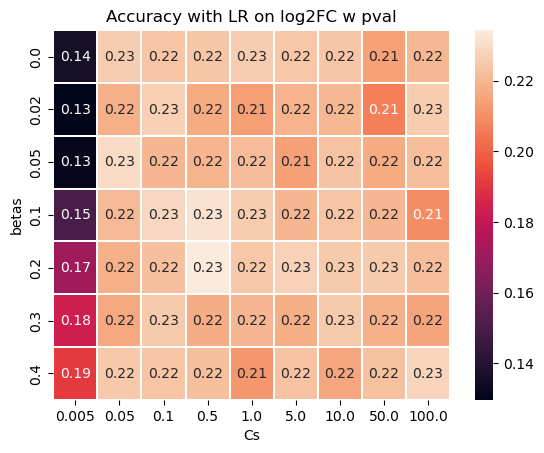

In [16]:
lasso_inv_p(betas, Cs, lfc_mb_filt, qval_mb_filt, value_cols)

In [17]:
def lasso_min_p(lfc, qval, C, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values
    # replace values lower than 0.05 with 0.05
    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    # print(X,y)
    accuracy = []
    X = X*(1-qval)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_hat))
    print(accuracy)
    # return accuracy

In [ ]:
lasso_min_p(lfc_mb_filt, qval_mb_filt, 10, value_cols)

## With lfc only - mycobrowser

In [ ]:
%reset -f

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, normalize
from imblearn.over_sampling import SMOTE

%matplotlib inline


In [2]:
lfc_mb_filt = pd.read_csv(
    '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')

In [3]:
value_cols = [col for col in lfc_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [4]:
### Newest multilabel classifier code ###
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Suppress specific warnings from XGBoost
warnings.filterwarnings(action='ignore', category=UserWarning, module='xgboost')

def lr_w_lasso_multilabel(mat, cols, C, norm_method, classifier, name, threshold=0.5, n_splits=3, figsize=(7, 7), save_path=None):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mlb = MultiLabelBinarizer()
    y_multi = mlb.fit_transform([[label] for label in y])
    
    y_true_all = []
    y_pred_all = []
    y_score_all = []
    
    with tqdm(total=n_splits, desc="Cross-validation") as pbar:
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_multi[train_index], y_multi[test_index]
            
            if norm_method == 'SMOTE':
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            
            if classifier == 'lr':
                base_clf = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)
            elif classifier == 'rf':
                base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
            elif classifier == 'xgb':
                base_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
                
            clf = OneVsRestClassifier(base_clf)
            clf.fit(X_train, y_train)
            
            y_score = clf.predict_proba(X_test)
            y_hat = (y_score >= threshold).astype(int)
            
            y_true_all.extend(y_test)
            y_pred_all.extend(y_hat)
            y_score_all.extend(y_score)
            
            accuracy.append(accuracy_score(y_test, y_hat))
            pbar.update(1)
    
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_score_all = np.array(y_score_all)
    
    # Per-class metrics
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []
    
    print(f"\nPer-class metrics for {name}:")
    for i, class_name in enumerate(col_names):
        precision = precision_score(y_true_all[:, i], y_pred_all[:, i])
        recall = recall_score(y_true_all[:, i], y_pred_all[:, i])
        f1 = f1_score(y_true_all[:, i], y_pred_all[:, i])
        roc_auc = roc_auc_score(y_true_all[:, i], y_score_all[:, i])
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        roc_aucs.append(roc_auc)
        
        print(f"\nClass {i} - {class_name}:")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-score: {f1:.3f}")
        print(f"  ROC AUC: {roc_auc:.3f}")
    
    # Global metrics (macro average)
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    macro_roc_auc = np.mean(roc_aucs)
    
    print(f"\nGlobal Metrics (Macro Average) for {name}:")
    print(f"  Precision: {macro_precision:.3f}")
    print(f"  Recall: {macro_recall:.3f}")
    print(f"  F1-score: {macro_f1:.3f}")
    print(f"  ROC AUC: {macro_roc_auc:.3f}")
    
    # Plot ROC curves with white background and no grid
    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(col_names):
        fpr, tpr, _ = roc_curve(y_true_all[:, i], y_score_all[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_aucs[i]:.2f})')  
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=24)
    plt.ylabel('True Positive Rate', fontsize=24)
    plt.legend(loc="lower right", fontsize=18)
    plt.gca().set_facecolor('white')  # Set the background color to white
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.tick_params(axis='y', which='both', left=True, right=False)  
    plt.grid(False)  
    plt.tight_layout()  
    
    # Save plot as PNG file 
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
  
    plt.show()
    
    return None

Cross-validation: 100%|██████████████████████████| 5/5 [10:12<00:00, 122.50s/it]



Per-class metrics for Accuracy_log2FC_XGB_Multilabel_SMOTE_C=10:

Class 0 - PE/PPE:
  Precision: 0.833
  Recall: 0.309
  F1-score: 0.450
  ROC AUC: 0.849

Class 1 - cell wall and
cell processes:
  Precision: 0.444
  Recall: 0.104
  F1-score: 0.168
  ROC AUC: 0.583

Class 2 - information pathways:
  Precision: 0.200
  Recall: 0.066
  F1-score: 0.099
  ROC AUC: 0.697

Class 3 - insertion seqs
and phages:
  Precision: 0.850
  Recall: 0.359
  F1-score: 0.505
  ROC AUC: 0.816

Class 4 - intermediary metabolism
and respiration:
  Precision: 0.507
  Recall: 0.151
  F1-score: 0.233
  ROC AUC: 0.611

Class 5 - lipid metabolism:
  Precision: 0.654
  Recall: 0.063
  F1-score: 0.115
  ROC AUC: 0.586

Class 6 - regulatory proteins:
  Precision: 0.176
  Recall: 0.015
  F1-score: 0.028
  ROC AUC: 0.643

Class 7 - virulence, detoxification,
adaptation:
  Precision: 0.500
  Recall: 0.032
  F1-score: 0.060
  ROC AUC: 0.626

Global Metrics (Macro Average) for Accuracy_log2FC_XGB_Multilabel_SMOTE_C=10:
 

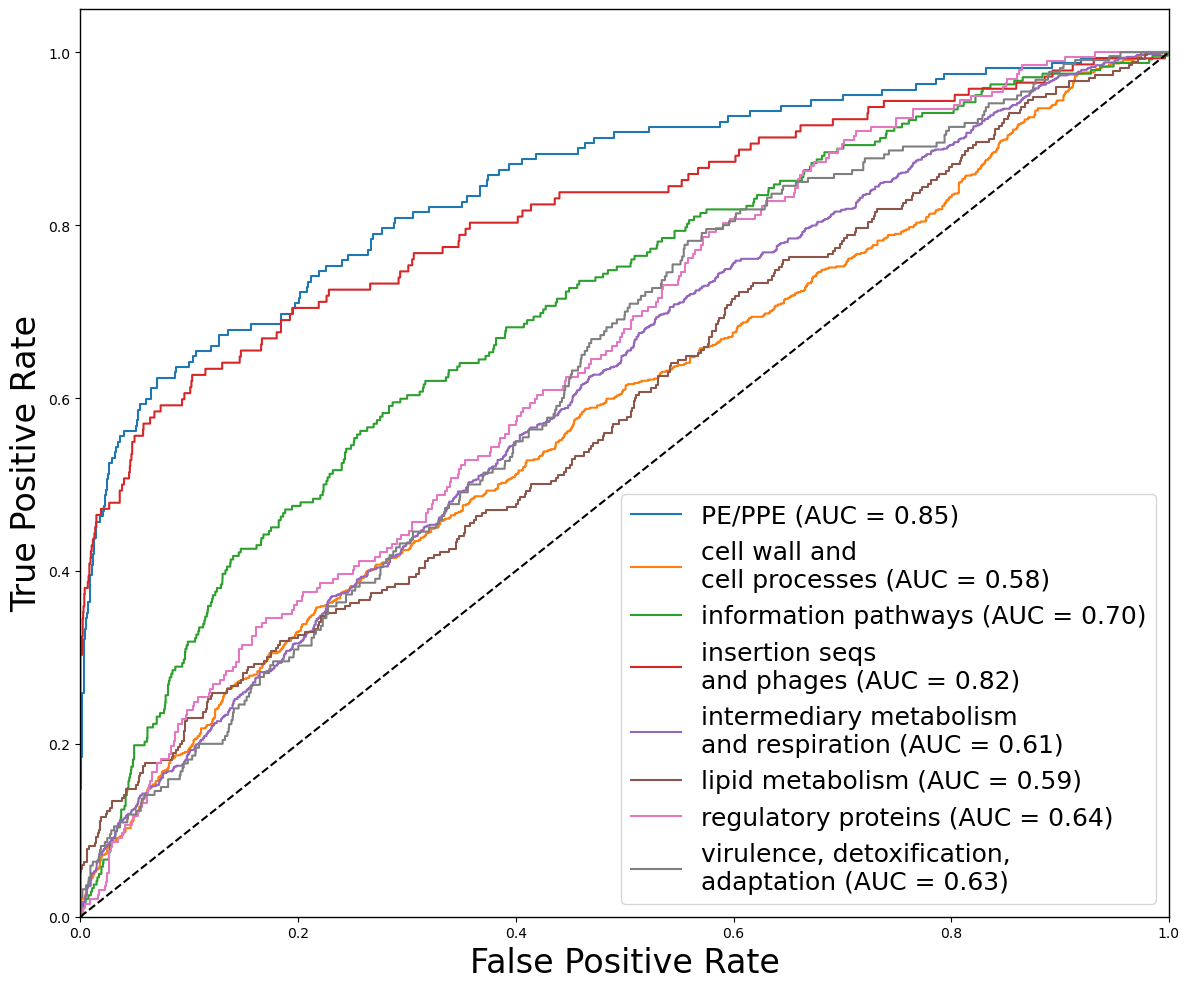

In [5]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']] 

lr_w_lasso_multilabel(lfc_mb_filt, value_cols, C=10, n_splits=5,
                norm_method='SMOTE', classifier='xgb', name='Accuracy_log2FC_XGB_Multilabel_SMOTE_C=10', save_path= 'Accuracy_log2FC_XGB_Multilabel_ROC_curve.png')

In [6]:
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform([[label] for label in lfc_mb_filt['Functional_Category']])


category_counts = pd.DataFrame(y_multi, columns=mlb.classes_).sum()

print("Count of genes in each functional category:")
print(category_counts)

multi_category_counts = (y_multi.sum(axis=1) > 1).sum()
none_category_counts = (y_multi.sum(axis=1) == 0).sum()

print(f"\nNumber of genes sorted into multiple categories: {multi_category_counts}")
print(f"Number of genes not sorted into any category: {none_category_counts}")


Count of genes in each functional category:
PE/PPE                                     162
cell wall and cell processes               771
information pathways                       242
insertion seqs and phages                  142
intermediary metabolism and respiration    933
lipid metabolism                           270
regulatory proteins                        197
virulence, detoxification, adaptation      220
dtype: int64

Number of genes sorted into multiple categories: 0
Number of genes not sorted into any category: 0


In [ ]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']] 

lr_w_lasso_multilabel(lfc_mb_filt, value_cols, C=10, n_splits=5,
                norm_method='SMOTE', classifier='lr', name='Accuracy_log2FC_LR_Multilabel_SMOTE_C=10')

In [ ]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']] 

lr_w_lasso_multilabel(lfc_mb_filt, value_cols, C=10, n_splits=5,
                norm_method='SMOTE', classifier='rf', name='Accuracy_log2FC_RF_Multilabel_SMOTE_C=10')

In [ ]:
lasso_confusion(lfc_mb_filt, value_cols, C=10,
                norm_method='SMOTE', name='Accuracy_log2FC_LR_Multilabel_SMOTE_C=10')

In [ ]:
lasso_confusion(lfc_mb_filt, value_cols, C=10, norm_method='bal_weights',
                name='Accuracy_log2FC_LR_balweights_C=10')

In [ ]:
lasso_confusion(lfc_mb_filt, value_cols, C=10, norm_method=None,
                name='Accuracy_log2FC_LR_NoNorm_C=10')

In [ ]:
lfc_mb_filt.Functional_Category.value_counts()

In [ ]:
lasso_coefs(lfc_mb_filt, value_cols, 10, 'SMOTE').to_csv(
    'results/coefs_mb_lfc_SMOTE_C10.csv')

## With binary

In [ ]:
%reset -f

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, normalize
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [ ]:
bin_mb_filt = pd.read_csv(
    '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/bin_mb_filt.csv')

In [ ]:
binary_data_cols = [col for col in bin_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [ ]:
lasso_vanilla(bin_mb_filt, binary_data_cols, Cs=[0.005, 0.05, 0.1, 1, 10, 50])

In [ ]:
lasso_confusion(bin_mb_filt, binary_data_cols, C=10,
                norm_method='SMOTE', name='Accuracy_bin_LR_SMOTE_C=10')

In [ ]:
lasso_confusion(bin_mb_filt, binary_data_cols, C=10,
                norm_method='bal_weights', name='Accuracy_bin_LR_balweights_C=10')

## With log2FC and binary

In [ ]:
%reset -f

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import pathlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import normalize, label_binarize
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
lfc_mb_filt = pd.read_csv(
    '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
bin_mb_filt = pd.read_csv(
    '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/bin_mb_filt.csv')
assert (lfc_mb_filt.columns == bin_mb_filt.columns).all()

In [ ]:
value_cols = [col for col in lfc_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [ ]:
bin_mb_filt = bin_mb_filt.rename(
    columns={col: col + '_bin' for col in value_cols})

In [ ]:
lfc_bin_mb = pd.merge(lfc_mb_filt, bin_mb_filt, how='left', on='Rv_ID').rename(columns={
    'Functional_Category_y': 'Functional_Category'}).drop(columns=['Functional_Category_x'])

In [ ]:
lfc_bin_mb.to_csv(
    '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/bin_mb_filt.csv', index=False)

In [ ]:
lfc_bin_cols = [col for col in lfc_bin_mb.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [ ]:
lasso_vanilla(lfc_bin_mb, lfc_bin_cols, Cs=[0.005, 0.05, 0.1, 1, 10, 50])

In [ ]:
lasso_confusion(lfc_bin_mb, lfc_bin_cols, C=10,
                norm_method='SMOTE', name='Accuracy_lfc_bin_LR_SMOTE_C=10')

# umap with log2fc

In [ ]:
%reset -f

In [ ]:
import pandas as pd
import pathlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import normalize
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
umap_10 = pd.read_csv('../data/tests/df_umap_10.csv')
umap = pd.read_csv('../data/tests/df_umap.csv')

In [ ]:
umap.head()

In [ ]:
umap = umap.drop(columns=['gene_name', 'func_tuberculist', 'COG'])
umap_10 = umap_10.drop(columns=['gene_name', 'func_tuberculist', 'COG'])

In [ ]:
lfc_mb_filt = pd.read_csv(
    '../data/standardized_data/cleaned_ML/lfc_mb_filt.csv')
lfc_mb_filt.head()

In [ ]:
lfc_umap = lfc_mb_filt.merge(umap, how='left', on='Rv_ID')
lfc_umap_10 = lfc_mb_filt.merge(umap_10, how='left', on='Rv_ID')

In [ ]:
lfc_umap.isna().sum()

In [ ]:
#fill empty umaps with zero
lfc_umap = lfc_umap.fillna(0)
lfc_umap_10 = lfc_umap.fillna(0)


In [ ]:
lfc_umap_value_cols = [col for col in lfc_umap.columns if col not in ['Rv_ID', 'Functional_Category']]
lasso_confusion(lfc_umap, lfc_umap_value_cols, C=10, norm_method='SMOTE',
                name='Accuracy_log2FC_umap_LR_SMOTE_C=10')

In [ ]:
lfc_umap_10_value_cols = [col for col in lfc_umap_10.columns if col not in ['Rv_ID', 'Functional_Category']]
lasso_confusion(lfc_umap_10, lfc_umap_10_value_cols, C=10, norm_method='SMOTE',
                name='Accuracy_log2FC_umap_10_LR_SMOTE_C=10')